In [14]:
from pyspark.sql import SparkSession
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

spark = SparkSession.builder \
    .appName("Crypto Data Analysis") \
    .getOrCreate()

In [8]:
spark_df = spark.read.csv("crypto prices.csv", header=True)

In [9]:
spark_df.show(5)

+---+-----------+------+--------+---------+-------------+-----------+--------------------+
| id|    coin_id|symbol|    name|price_usd|   market_cap| volume_24h|           timestamp|
+---+-----------+------+--------+---------+-------------+-----------+--------------------+
|  1|    bitcoin|   btc| Bitcoin|   105009|2087072749203|28266144032|2025-06-04 15:45:...|
|  2|   ethereum|   eth|Ethereum|  2624.56| 316902810125|15239045711|2025-06-04 15:45:...|
|  3|     tether|  usdt|  Tether|      1.0| 153377158195|41036196023|2025-06-04 15:45:...|
|  4|binancecoin|   bnb|     BNB|   667.53|  97388908131|  606073963|2025-06-04 15:45:...|
|  5|     solana|   sol|  Solana|   155.75|  81378191951| 3451824396|2025-06-04 15:45:...|
+---+-----------+------+--------+---------+-------------+-----------+--------------------+
only showing top 5 rows


In [ ]:
df = spark_df.toPandas()
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values(['symbol', 'timestamp'])
df = df.set_index('timestamp') 


In [12]:
symbols = df['symbol'].unique()

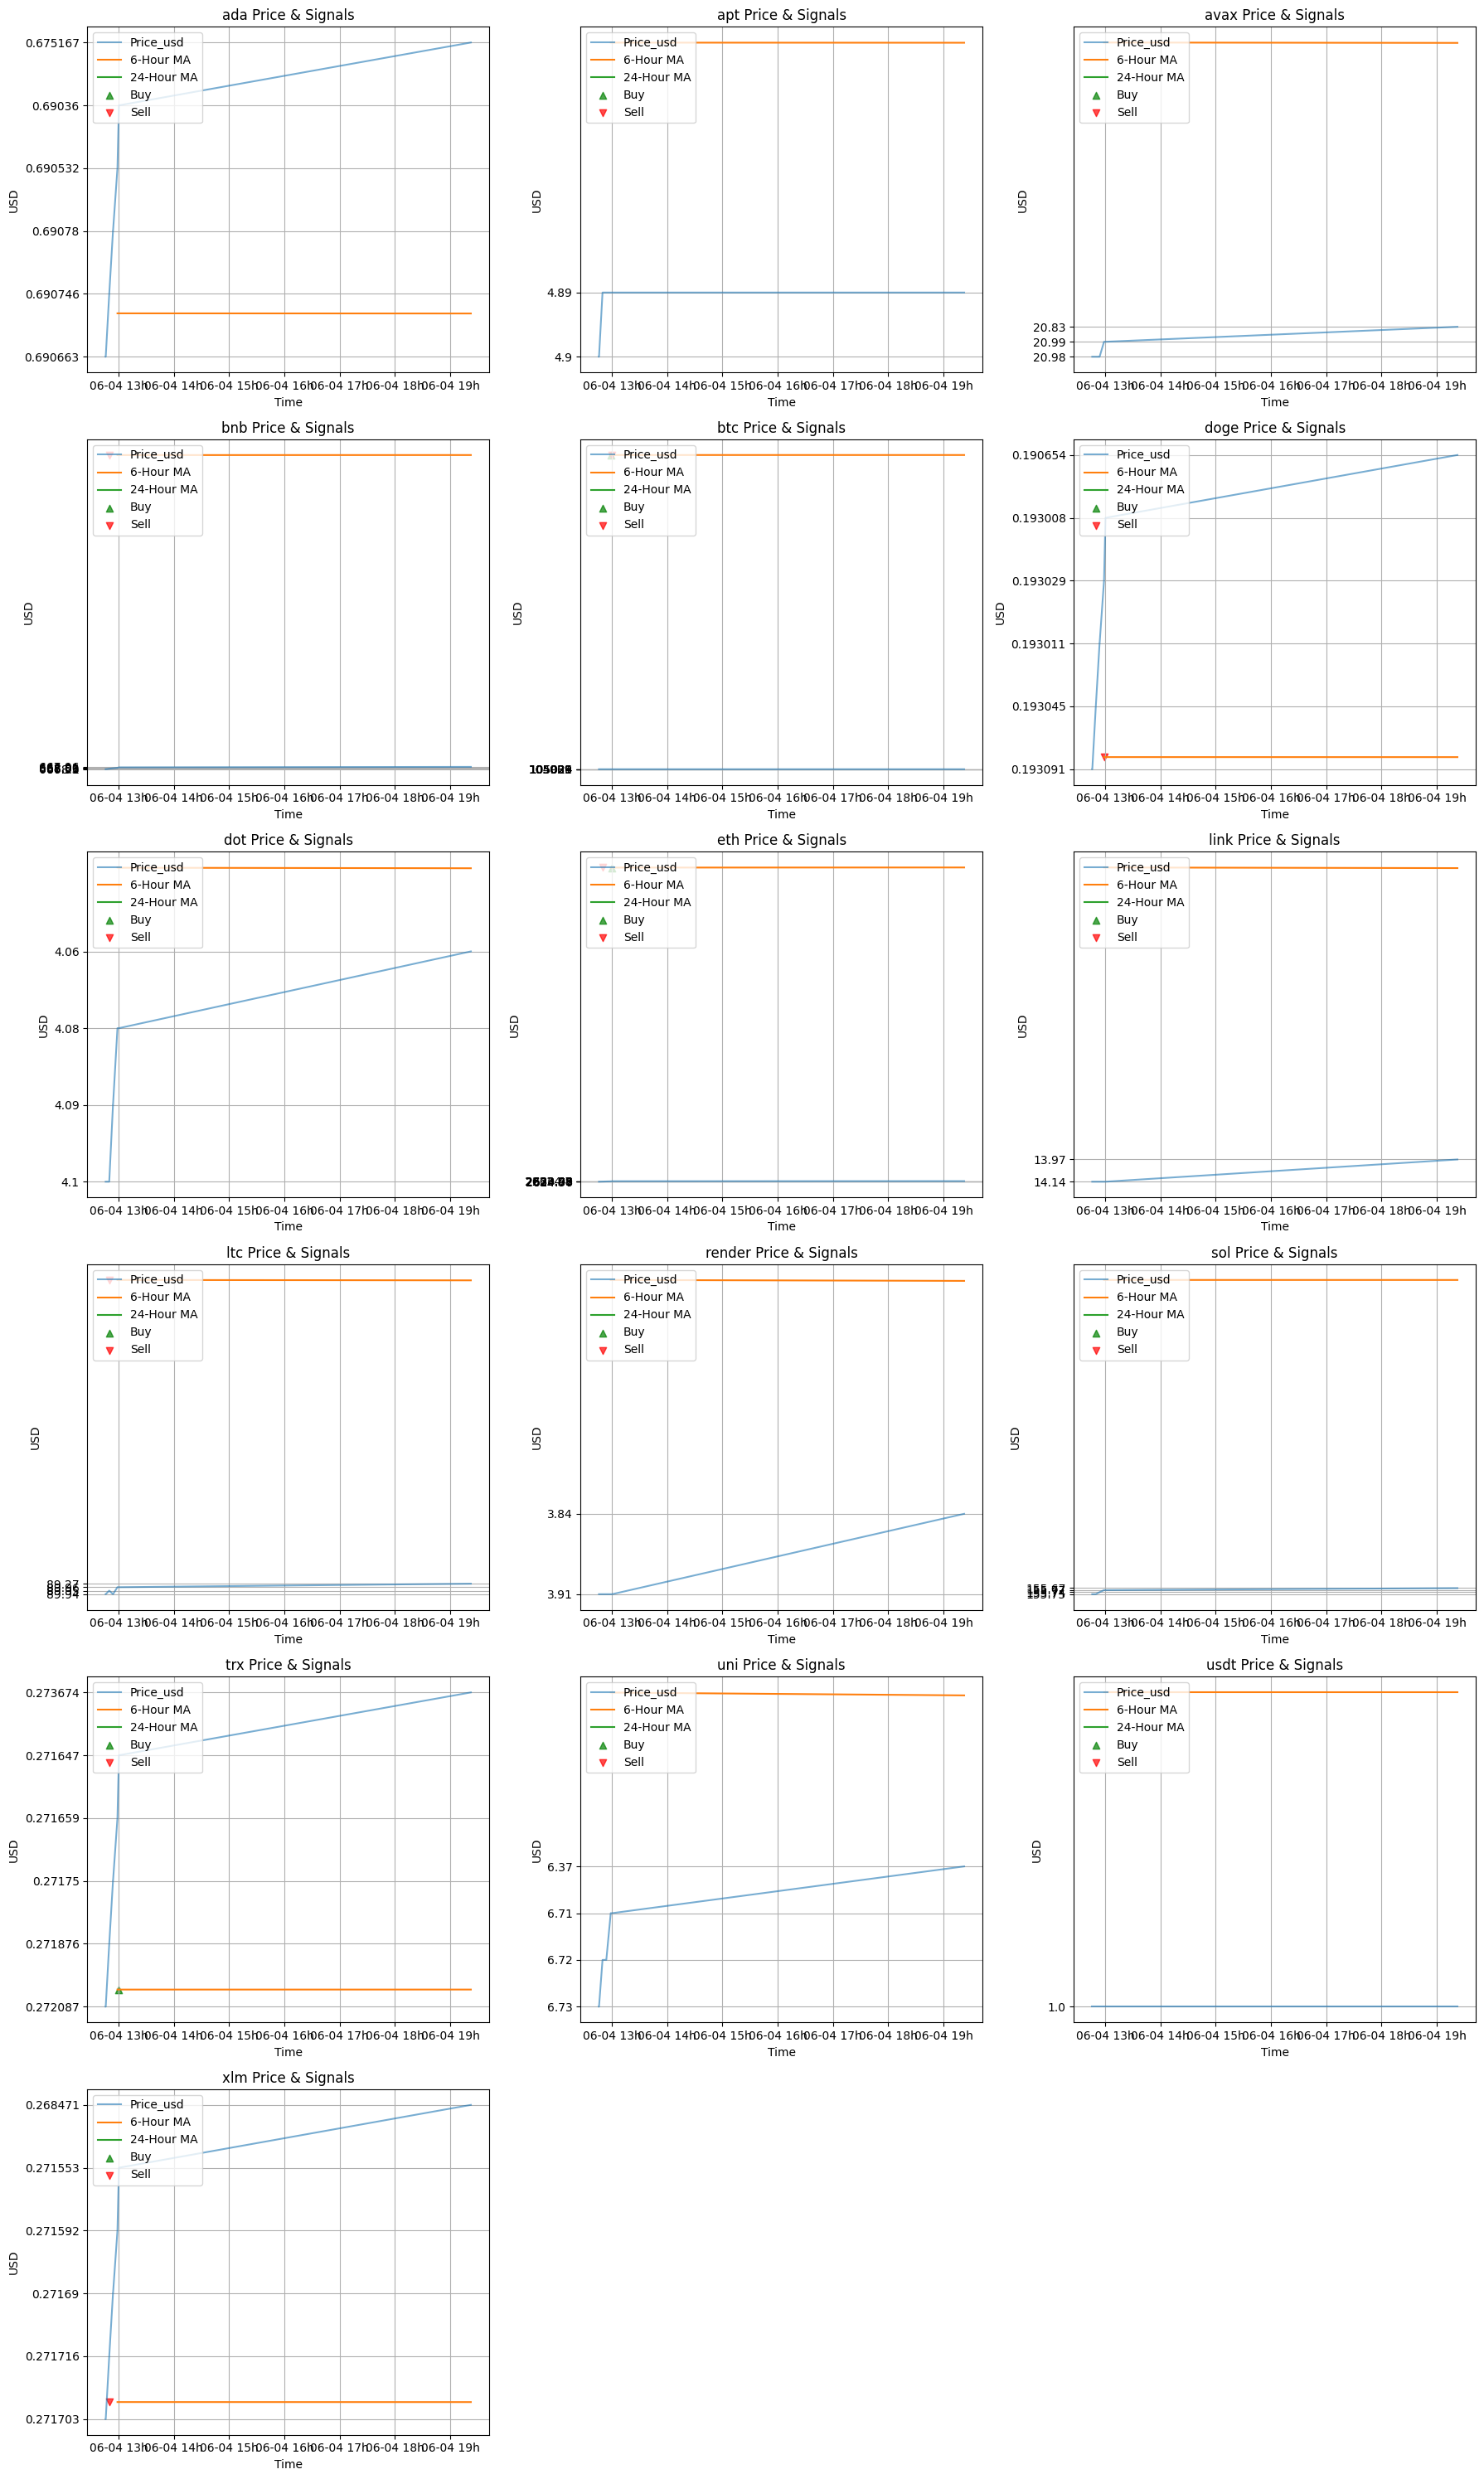

In [16]:
rows = (len(symbols) + 2) // 3
fig, axes = plt.subplots(rows, 3, figsize=(18, 5 * rows), sharex=False)
axes = axes.flatten()

for i, symbol in enumerate(symbols):
    coin_df = df[df['symbol'] == symbol].copy()

    # Calculate moving averages
    coin_df['MA_6'] = coin_df['price_usd'].rolling(window=6).mean()
    coin_df['MA_24'] = coin_df['price_usd'].rolling(window=24).mean()

    # Detect local minima (buy) and maxima (sell)
    coin_df['min'] = coin_df['price_usd'][
        (coin_df['price_usd'].shift(1) > coin_df['price_usd']) & (coin_df['price_usd'].shift(-1) > coin_df['price_usd'])
    ]
    coin_df['max'] = coin_df['price_usd'][
        (coin_df['price_usd'].shift(1) < coin_df['price_usd']) & (coin_df['price_usd'].shift(-1) < coin_df['price_usd'])
    ]

    ax = axes[i]
    ax.plot(coin_df.index, coin_df['price_usd'], label='Price_usd', alpha=0.6)
    ax.plot(coin_df.index, coin_df['MA_6'], label='6-Hour MA')
    ax.plot(coin_df.index, coin_df['MA_24'], label='24-Hour MA')
    ax.scatter(coin_df.index, coin_df['min'], color='green', label='Buy', marker='^', alpha=0.7)
    ax.scatter(coin_df.index, coin_df['max'], color='red', label='Sell', marker='v', alpha=0.7)

    ax.set_title(f'{symbol} Price & Signals')
    ax.set_xlabel('Time')
    ax.set_ylabel('USD')
    ax.grid(True)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %Hh'))
    ax.legend(loc='upper left')

# Remove extra empty axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()